In [586]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter
import pickle
import community
from statistics import mode
import seaborn as sn
import datetime
import random
import pprint
from scipy.stats import norm

# Network analysis

In this part we will analyse the network of directors. The nodes of the network are directors and two directors are connected if they have ever hired the same actor. We will analyse the structure of the network and the centrality of nodes. Then we will analyse the communities of the network.

In [576]:
# load network
g = nx.read_gpickle("popular_directors_network.gpickle")

In [393]:
print('number of nodes',g.number_of_nodes())

number of nodes 1273


In [394]:
print('number of edges',g.number_of_edges())

number of edges 217725


The network consists of 1273 nodes and 217,725 edges. 

## Degree analysis
Let's take a look at the degree distribution of the network. Are there some directors who are connected to a large portion of the other directors? Are there any directors who are only connected to very few others? Are there any direcctors who are not connected to any of the others?

What about the structure of the network? Does it have a power law degree distribution? Does the small-world property hold?

First lets take a look at the giant component

In [441]:
# extract subgraphs
subgraphs = list(nx.connected_component_subgraphs(g))
# find largest subgraph
gc = max(subgraphs, key=len)
print('There are {} subgraphs'.format(len(subgraphs)))
print('with sizes',[graph.number_of_nodes() for graph in subgraphs])

There are 2 subgraphs
with sizes [1272, 1]


So there is one node that is not connected to the rest of the graph. Which director is this and how come he is not connected to the rest?

In [435]:
# get the node of the other subgraph
d = list(subgraphs[1].nodes())[0]
print('name', d)
print('number of movies', len(g.node[d]['movies']))
print('last movie', g.node[d]['last_movie'])

name Georges Méliès
number of movies 49
last movie 1912-01-01


In [432]:
# get date of the 10 earliest directors first movie
sorted(nx.get_node_attributes(gc,'first_movie').items(), key=lambda x: x[1])[:10]

[('Cecil B. DeMille', '1914-02-14'),
 ('Charlie Chaplin', '1914-06-20'),
 ('Michael Curtiz', '1915-03-20'),
 ('Raoul Walsh', '1915-09-12'),
 ('Buster Keaton', '1917-06-25'),
 ('John Ford', '1917-08-27'),
 ('Ernst Lubitsch', '1917-11-30'),
 ('Fritz Lang', '1919-10-03'),
 ('F.W. Murnau', '1921-04-07'),
 ('Frank Capra', '1922-04-01')]

The lone node is the french illusionis Georges Méliès. He has directed quite a few movies, all of which are short films. His last film was released in 1912. We do have a few other directors who worked in the early 1900s but it does make sense though that Georges Méliès is not connected to any of these. 

We will only work with the giant component from now on.

### Illustration
Now we will try to draw the network well knowing that the plot might not be very insightful for such a big, dense network. 

In [587]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=False)

positions = forceatlas2.forceatlas2_networkx_layout(gc, pos=None, iterations=5000)

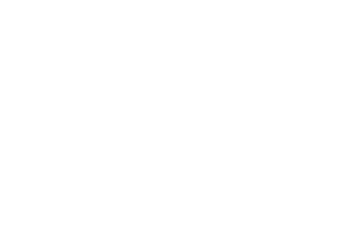

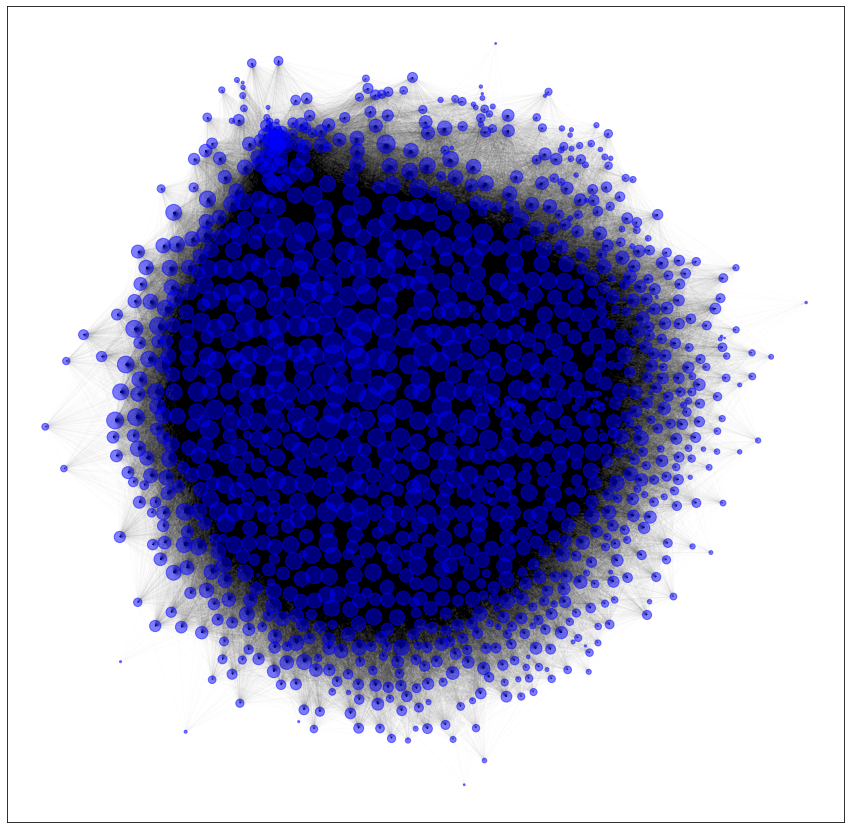

In [589]:
# plot network setting node sizes based on degrees
d = gc.degree()
plt.axis('off')
plt.figure(figsize=(15,15))
degrees = [d[node]*0.5 for node in gc.nodes()]
nx.draw_networkx_nodes(gc,positions,node_color='blue', node_size= degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(gc, positions, alpha=0.01)
plt.show()


The plot above shows a very dense network and we cannot really see what is going on. We need to analyse the network in other ways to gain insights.

## Degree distribution
Now we will take a closer look at the degree distribution and what it says about the network.

#### Degree distribution as histogram

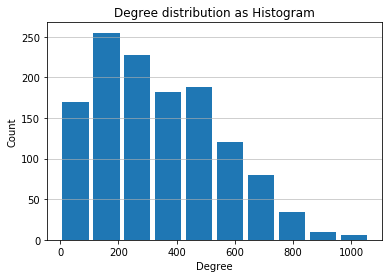

In [9]:
plt.hist(list(dict(nx.degree(g)).values()), rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.title("Degree distribution as histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

The figure above shows the degree distribution of the network. We see that the distribution is quite broad and most nodes have degrees between 100 and 300. 

#### Does the network structure resemble that of a random network?
The degree distribution of a random network does follow a Poisson distribution. To compare the degree distribution of our network with a Poisson we try to fit a normal distribution curve over the degree distribution to see how well it fits. 

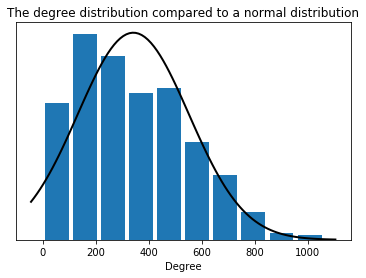

In [489]:
data =list(dict(nx.degree(g)).values())

# Fit a normal distribution to the data
mu, std = norm.fit(data)

# Plot 
plt.hist(data,density=True, rwidth=0.85)
xmin, xmax = plt.xlim()
plt.grid(axis='y', alpha=0.75)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plot = plt.plot(x, p, 'k', linewidth=2)
plt.xlabel("Degree")
plt.yticks([])

title = "The degree distribution compared to a normal distribution"
plt.title(title)

plt.show()

As can be seen in the above figure, the destribution does not correspond very well to a normal distribution and hence the structure of the network is not like that of a random network. 

### Is this a scale-free network?
A scale-free network is a network whose degree distribution follows a power law. (ch. 4 in networks book). The power law states that there are a lot of nodes with a very small degree and a few nodes with a very high degree. When plotting the degree distribution of a network that follows the power law with loglog axes it should resemble a straigh line (or close to that). 

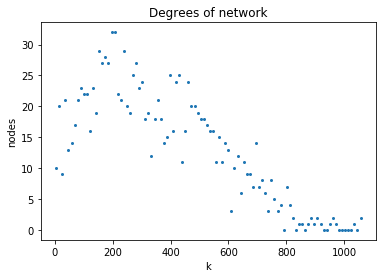

In [383]:
# Plot degree distribution again, this time as a point plot
degrees = [o[1] for o in list(g.degree)]
h = np.histogram(degrees, bins=100)
avgValues = []
for i in range(len(h[1])-1):
    avgValues.append((h[1][i]+h[1][i+1])/2)
    
plt.plot(avgValues,h[0], 'o', markersize=2)
plt.xlabel('k')
plt.ylabel('nodes')
plt.title('Degrees of network')
plt.show()

It does not look like it follows the power law. Let's plot it using log-log axes.

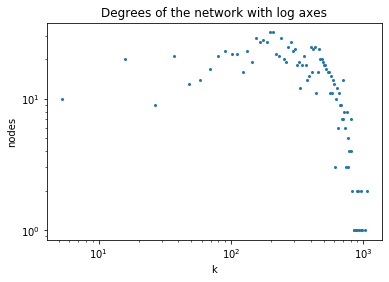

In [387]:
# Plot degree distribution using log log axes
plt.yscale('log')
plt.xscale('log')
plt.plot(avgValues,h[0], 'o', markersize=2)
plt.xlabel('k')
plt.ylabel('nodes')
plt.title('Degrees of the network with log axes')
plt.show()

It does not really follow the power law but it is still a very broad distribution meaning that the difference between the minum degree and the maximum degree is very large. 

### Is the friendship paradox true in this network?
In a nework with a power-law degree distribution the friendship paradox is true. The paradox states that almost everyone has fewer friends than their friends have on average. Meaning that the degree of most nodes is lower that the average degree of its neighbours. 
Even though we found that our network does not really have a power-law degree distribution let's check if the friendship paradox is true.

In [505]:
result = []
# go though all nodes and check if the paradox is true for that node
for n in gc.nodes():
    # degree of node
    degree = g.degree(n)
    
    # avg degree of neighbours
    neigbors = g.neighbors(n)
    avg = np.mean([o[1] for o in g.degree(neigbors)])
    result.append(avg > degree)
    

print('Paradox is true {} % of the time'.format((result.count(True)/ tries)*100 ))

Paradox is true 92.4 % of the time


The friendship paradox is true for 92.4% of the nodes, so the network does still have some properties of a real-life network.

### The small world property
Does the small world propery hold in our network? The small-world property states that the distance between two nodes is very small compared to the size of the network. (ch. 3 in Network Science book)


First lets calculate the diameter of the network. The diameter is also the length of the longest shortest path between any two nodes.

In [508]:
print('diameter',nx.diameter(gc))

diameter 4


A diameter of 4 on a network with over 1200 nodes does indeed seem quite small, but lets use the mathematical formulation of the small world phenomenon to state whether our network does have the small world property.

$\langle d \rangle \approx \frac{\log n}{\log \langle k \rangle}$ (eq. 3.19 in Network Science book)

The equation states that the average distance between nodes should be approximately equal to the natural logarithm of the number of nodes divided by the natural logarithm of the average degree.

In [389]:
avg_degree = np.average(degrees_list)
avg_distance = nx.average_shortest_path_length(gc)

In [507]:
print('right-hand side',np.log(gc.number_of_nodes())/np.log(avg_degree))

right-hand side 1.2249149367846073


In [509]:
print('left-hand side',avg_distance)

left-hand side 1.7416893052071116


These two numbers are very similar and hence we state the the network does have the small world property.

### Conclusion regarding degree distribution
The network does not resemble a random network but it does not have a clear power-law degree distribution either. However the friendship paradox is true for 92.4% percente of the nodes and it does have the small world property. To sum up it does resemble a real-life network more than a random network.

## What are the most central nodes?
To determine which directors are most central in the network we will use three different methods of centrality: degree centrality, betweeness centrality and eigenvector centrality. 

### Degree centrality
The degree of a node is the number of neighbours or rephrased as the number of other nodes the node is connected to.

In [523]:
# get degrees
degrees = gc.degree()
# construct sorted list of names and degrees
list_degrees_with_names = sorted(degrees, key=lambda x: x[1], reverse=True)

In [524]:
degrees_list =[x[1] for x in degrees]
print('Statistics about the degrees')
print('average: ', np.average(degrees_list))
print('median: ', np.median(degrees_list))
print('mode: ', mode(degrees_list))
print('min: ', np.min(degrees_list))
print('max: ', np.max(degrees_list))

Statistics about the degrees
average:  342.33490566037733
median:  308.0
mode:  156
min:  5
max:  1061


In [521]:
print('Director connected to most other directors is',list_degrees_with_names[0][0])
print('Has actors in common with ' + str(list_degrees_with_names[0][1]) + ' different directors')

Director connected to most other directors is Woody Allen
Has actors in common with 1061 different directors


There is a big difference in the minimum degree and the maximum degree. The minimum is only 5 while the maximum is 1061 which is quite close to the number of nodes in the network, 1273. The most common degree is 156, the average is 342 and the median is 308. This tells us that there are a few very high degree nodes that push the average up.

Now will we find the 5 most central nodes regarding degree centrality.

In [11]:
print('Top 5 directors regarding degree')
for name,_ in (list_degrees_with_names)[0:5]:
    print(name)

Top 5 directors regarding degree
Woody Allen
Steven Spielberg
Ridley Scott
Martin Scorsese
Oliver Stone


The top 5 directors regarding degree centrality are all famous directors. 

### Betweeness centrality
Now we look at betweeness centrality instead of degree centrality. Betweeness centrality indicates how many shortest paths go through a node and is therefore a good meassure of how central a node is in a network.

In [439]:
betweeness_centrality = nx.betweenness_centrality(gc)

In [440]:
# get list sorted by betweeness centrality
list_betweeness_centrality = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)
print('Top 5 directors regarding betweeness centrality')
for name,d in (list_betweeness_centrality)[0:5]:
    print(name)

Top 5 directors regarding betweeness centrality
Ridley Scott
Woody Allen
Steven Spielberg
Martin Scorsese
Ron Howard


We see that the top 3 nodes are the same as the top three regarding degree centrality but in a different order.

### Eigenvector centrality
Next we will take a look at eigenvector centrality. The eigenvector centrality measures the centrality of a node based on the centrality of its neighbours. If a node is connected to many nodes that have a high eigenvector centrality then that node will have high eigenvector centrality. This is an indicator of the influence a node has in the network.

In [15]:
eigenvector_centrality = nx.eigenvector_centrality(gc)
# get list sorted by eigenvector centrality
list_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print('Top 5 directors regarding eigenvector centrality')
for name,d in (list_eigenvector_centrality)[0:5]:
    print(name)

Top 5 directors regarding eigenvector centrality
Steven Spielberg
Woody Allen
Ridley Scott
Martin Scorsese
Oliver Stone


Again we see the same nodes, but in a different order.

#### Who are these top three directors?
First of all they are all very famous. Lets find their ratings, their vote count and how many movies they have directed and compare to the rest of the network.

In [584]:
# get some details about the top three directors
top = ['Steven Spielberg','Woody Allen','Ridley Scott']
ratings =[x for x,_ in sorted(nx.get_node_attributes(gc,'rating').items(), key=lambda x: x[1],reverse=True)]
rating_counts =[x for x,_ in sorted(nx.get_node_attributes(gc,'rating_count').items(), key=lambda x: x[1],reverse=True)]
no_of_movies =[x for x,_ in sorted(nx.get_node_attributes(gc,'movies').items(), key=lambda x: len(x[1]),reverse=True)]
for director in top:
    print('{}\nno. of movies: {} ranking: {}'.format(director,len(gc.node[director]['movies']), no_of_movies.index(director) ))
    print('rating: {} ranking: {}'.format(gc.node[director]['rating'], ratings.index(director)))
    print('vote_count: {} ranking: {}'.format(gc.node[director]['rating_count'], rating_counts.index(director)))
    print('genres: {} '.format(list(dict.fromkeys(sorted(gc.node[director]['genres'], key=gc.node[director]['genres'].count, reverse=True)))[:3]))
    print('\n')

Steven Spielberg
no. of movies: 33 ranking: 29
rating: 6.894 ranking: 193
vote_count: 62266.0 ranking: 1
genres: ['Drama', 'Adventure', 'Action'] 


Woody Allen
no. of movies: 49 ranking: 4
rating: 6.692 ranking: 293
vote_count: 15512.0 ranking: 45
genres: ['Comedy', 'Drama', 'Romance'] 


Ridley Scott
no. of movies: 24 ranking: 70
rating: 6.604 ranking: 333
vote_count: 43083.0 ranking: 4
genres: ['Drama', 'Action', 'Thriller'] 




Their vote count and the number of movies they have made are high compared to the rest of the network, but their rating is not that high. This shows that directors who are central in the network do not necessary have a high rating. However their vote count is also an indicator of popularity or at least of how famous they are, and this is quite high for all of them. The fact that they all have a high number of movies is not surprising as this will of course give them a higher probality of being connected with other directors. Their genres are all very popular genres which also increases the likelihood that they share actors with other directors.

### Centrality conclusion
The three centrality meassures meassure centrality with emphasis on different things. The degree centrality meassures how many other directors a director is connected to. This would favor directors how have directed many movies and who have hired many popular actors, where popularity is defined by how many other directors an actor has worked for. The betweeness centrality of a node describes how many shortest paths go though this node. This says something about how important the director is in connecting other directors. The final centrality meassure, the eigenvector centrality of a node says how many other central nodes this node is connected to i.e. how many "important" director this director "knows".

The three most central directors are Steven Spielberg, Woody Allen and Ridley Scott in all three centrality meassures. These are all very famous directors who have directed many great movies. 


## Community detection
Now we will move on to analysing the communities within in network. We will find the best partition using the Louvain-algorithm. After finding the communities we will try to where these communities come from. We will do this by looking at some of the attributes that we have for the directors in our dataset. 

In [557]:
# find best partition using the Louvain-algorithm
partition = community.best_partition(gc)
print('Modularity:', community.modularity(partition, gc))

Modularity: 0.22823928603386023


The modularity is above 0 which means that there are more edges within the communities than there are across communities. However the modularity is not that high which means that the community are not that well defined. 

In [558]:
# get a dictionary of communities and directors for later use
communities = {}
for key, item in partition.items():
    gc.node[key]["community"] = item
    if item not in communities:
        communities[item] = []
    communities[item].append(key)

In [559]:
# print sizes of communties
print('Sizes of communities')
for c in communities.items():
    print(str(c[0])+ ': ' + str(len(c[1])))

Sizes of communities
0: 417
1: 223
2: 394
3: 90
4: 100
5: 48


In [608]:
# extract communities to csv file for later use
x = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in communities.items() ]))
x.to_csv('data/communities.csv')

### Illustration of communities

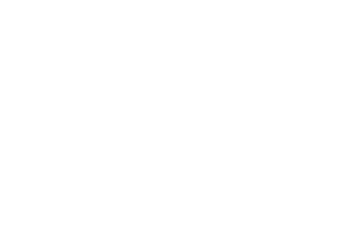

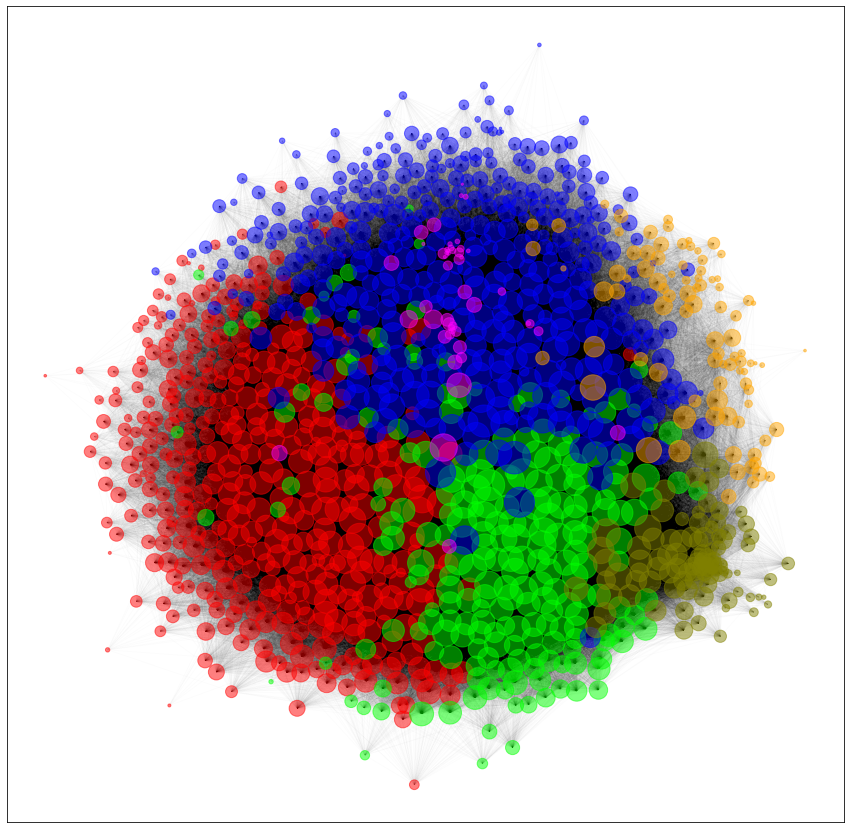

In [560]:
colours = ['red', 'lime', 'blue', 'orange', 'olive', 'magenta', 'Aqua', 'Brown', 'olive', 'pink', 'yellow', 'black', 'gray']
d = g.degree()
plt.axis('off')
plt.figure(figsize=(15,15))
for i,(_,com) in enumerate(communities.items()):
    com_degrees = [d[node] for node in com]
    nx.draw_networkx_nodes(gc,positions, nodelist=com,node_color=colours[i], node_size= com_degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(gc, positions, alpha=0.01)
plt.show()

The plot above illustrates the communities using different colours for each community. We see that the network is split into three bigger parts and two smaller parts at the right and one small community inside another one. 

### Analysis of the communities
Now we will dive deeper into the communities. We will look at three different attributes: language, genre, active period and rating, to see if anything can be said about the communities regarding these. We want to find out if the communities can be distinguished using any of these attributes. 

### Languages
First we will look at the languages of the directors. We will seperate the directors into groups of languages and create a confusion matrix to see if there is any correlation between communities and languages. 

In [577]:
# create dictionary for languages
# if directors have directed movies with languages other than english find the language that appeared the most times
# otherwise set language to english
# reason for not just setting language to majority: we lose some information about directors who have directed some 
# foreigh movies, but still mosty english, as their language will be set to english. We want to put ephasis on non-
# english directors.
lan_dict = {}
for d,l in nx.get_node_attributes(gc,'languages').items():
    # get list of languages that are not english
    foreign_l= [y for y in l if y != 'en']
    # if there are none, then set language to english
    if len(foreign_l) == 0:
        main_l = 'en'
    # otherwise find the majority
    else:
        main_l = max((foreign_l), key=foreign_l.count)
    if not main_l in lan_dict:
        lan_dict[main_l] = []
    lan_dict[main_l].append(d)

Now we will create the confusion matrix. Each cell is the percentage of the community that have that specific language. 

In [578]:
# create confusion matrix
confusion_matrix = np.zeros((len(lan_dict), len(communities)))

for i, l in enumerate(lan_dict.items(), start=0):
    for j, c in enumerate(communities.items(),start=0):
        in_community = len(list(set(c[1]).intersection(l[1])))
        total_in_community = len(set(c[1]))
        confusion_matrix[i][j] = 100*in_community/total_in_community

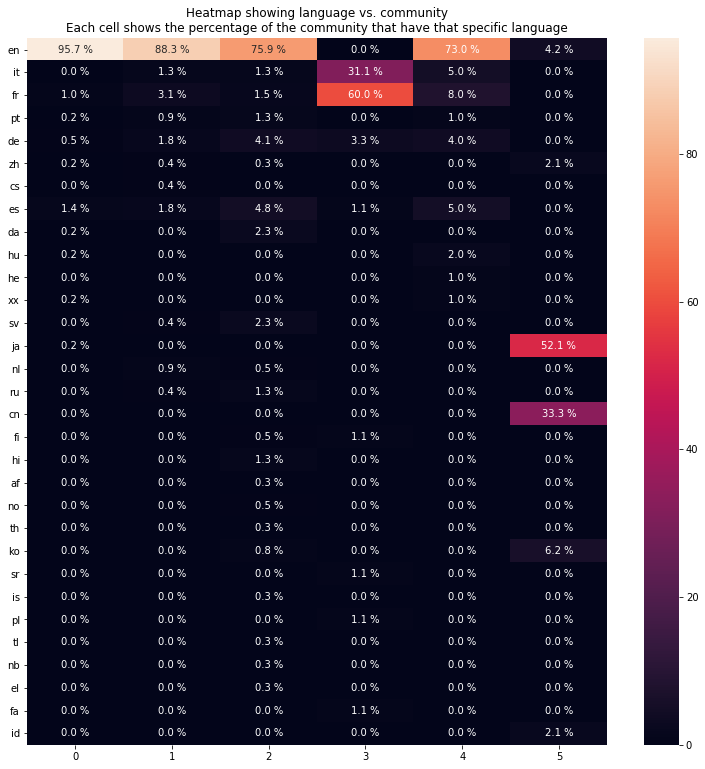

In [579]:
# plot heatmap of confusion matrix
plt.figure(figsize = (13,13))
yticklabels = [l for l in lan_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt=".1f")
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing language vs. community\nEach cell shows the percentage of the community that have that specific language')
for t in chart.texts: t.set_text(t.get_text() + " %")
plt.show()

Community 3 and 5 seem to be based on language. Community 3 mostly has mostly directors of french movies and some italian movies, community 5 mostly directors of japanese and cantonese movies. The other communities have mostly directors of english movies however community 2 does have a higher percentage of movies of many of the smaller languages than the other communities. 

### Genres
Now we will look at genres. We will create one group for each genre and add directors to the groups that they have worked whithin. One director might have worked in more than one genre as each movie can be labeled by multiple genres and many directors have also directed multiple movies. We will then create a confusion matrix to see if there is any correlation between communities and genres.

In [215]:
# create dictionary of genres and directors who have directed movies of that genre
# As most movies have multiple genres and many directors have directed multiple movies
# the same director might appear for multiple genres
genres_dict = {}
for d,genres in nx.get_node_attributes(gc,'genres').items():
    for genre in genres:
        if not genre in genres_dict:
            genres_dict[genre] = set()
        genres_dict[genre].add(d)

Then we create the confusion matrix. Each cell is the percentage of the community that have worked in that specific genre. As mentioned above, each directed might have worked in multiple genres therefor the percentages for one community do not add up to 100%.

In [286]:
# create confusion matrix
confusion_matrix = np.zeros((len(genres_dict), len(communities)))

for i, genre in enumerate(genres_dict.items(), start=0):
    directors_of_genre = len(set(genre[1]))
    for j, c in enumerate(communities.items(),start=0):
        in_community = len(list(set(c[1]).intersection(genre[1])))
        total_in_community = len(set(c[1]))
        confusion_matrix[i][j] = 100*(in_community/total_in_community)

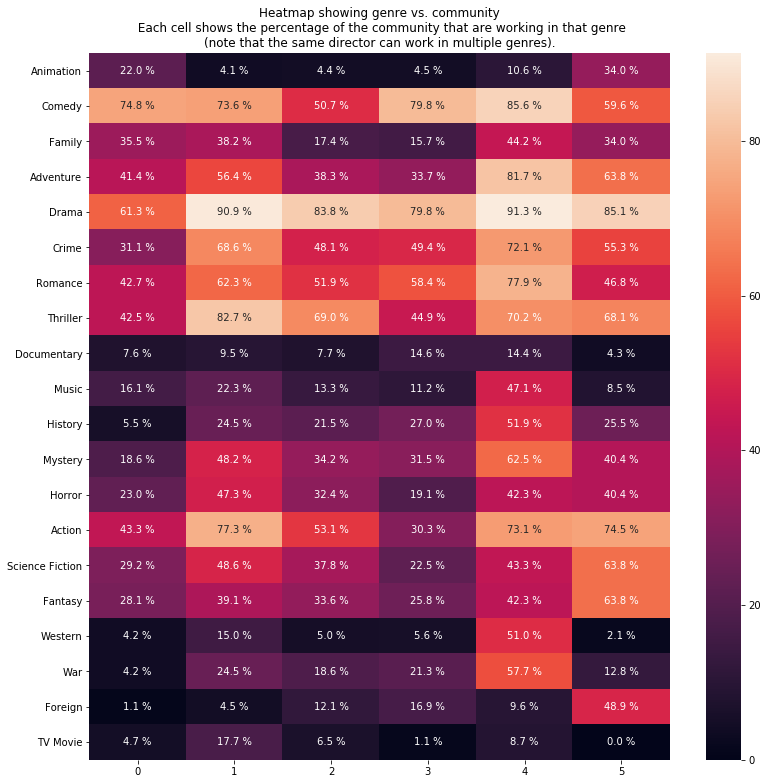

In [287]:
plt.figure(figsize = (13,13))
yticklabels = [l for l in genres_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt=".1f")
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing genre vs. community\n Each cell shows the percentage of the community that are working in that genre\n(note that the same director can work in multiple genres).')
for t in chart.texts: t.set_text(t.get_text() + " %")
plt.show()

All communities are a mix of multiple genres which makes sense since we know that directors and actors do not restrict themselves to a single genre. There are some genres that are quite common among all communities such as drama, comedy, romance, thriller and action. These are all genres that are somewhat general and a lot of movies will have these genres listed as their genre along with other more significant genres.

There are however some differences between the communities that might be of significans. Communty 4 has directors working in multiple genres that are not as common in the other communities such as music, history, mystery, western and war. 

Community 5 has a high percentage of directors working in the genres foreign, fantasy and science fiction. 

Community 1 has a high percentage of directors working in the genres thrillers, mystery, horror and science fiction. 

### Active period
Now we will look at active periods. We will create one group for each decade and add directors to the group if they were active in that decade. We define the active period of a director as the time from the release of the first movie to the release of the last movie. We will then create a confusion matrix to see if there is any correlation between communities and genres.

In [238]:
# create dictionary of decade and directors who have directed movies in that decade
period_dict = {1910:[], 1920:[], 1930:[], 1940:[], 1950:[], 1960:[], 1970:[], 1980:[], 1990:[], 2000:[], 2010:[]}
for d in gc.nodes():
    first_movie = datetime.datetime.strptime(gc.node[d]['first_movie'], '%Y-%m-%d')
    last_movie = datetime.datetime.strptime(gc.node[d]['last_movie'], '%Y-%m-%d')
    for p in period_dict.items():
        period_start = datetime.datetime(p[0], 1, 1, 0, 0)
        period_end = datetime.datetime(p[0]+9, 12, 31, 0, 0)
        if last_movie >= period_start and first_movie <= period_end:
            period_dict[p[0]].append(d)

Then we create the confusion matrix. Each cell is the percentage of the community that were active in that decade. A director can be active over a period of more than 10 years and hence can be in multiple groups. Therefor the percentages of each community do not add up to 100%.

In [241]:
confusion_matrix = np.zeros((len(period_dict), len(communities)))

for i, p in enumerate(period_dict.items(), start=0):
    directors_in_period = len(set(p[1]))
    for j, c in enumerate(communities.items(),start=0):
        in_community =len(list(set(c[1]).intersection(p[1])))
        total_in_community = len(set(c[1]))
        confusion_matrix[i][j] = 100*(in_community/total_in_community)

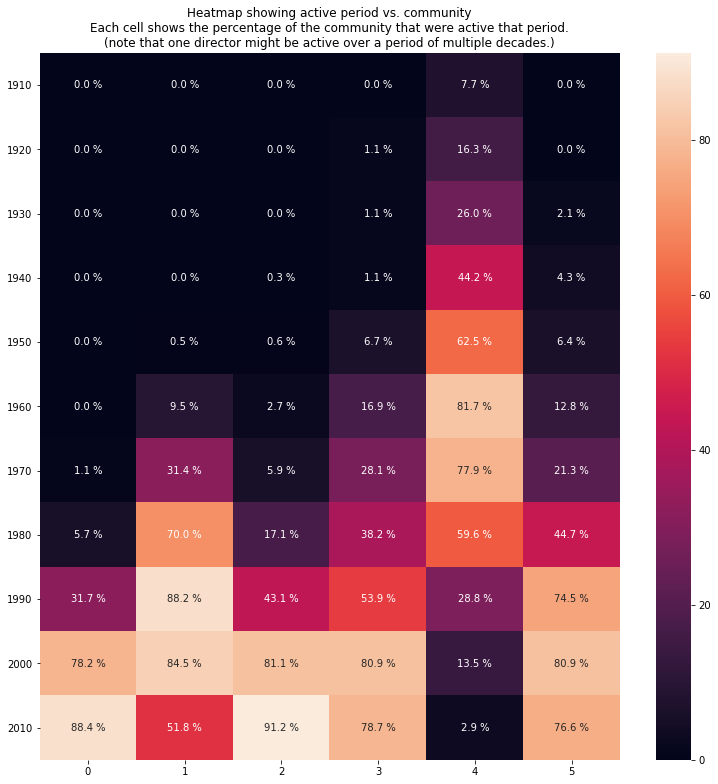

In [244]:
plt.figure(figsize = (13,13))
yticklabels = [l for l in period_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt=".1f")
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing active period vs. community\nEach cell shows the percentage of the community that were active that period.\n(note that one director might be active over a period of multiple decades.)')
for t in chart.texts: t.set_text(t.get_text() + " %")
plt.show()

From this figure we can see that community 4 consists mainly of older movies. It makes sense that the directors of older movies are grouped together as not many of the same actors are acting in older as well as newer movies. We can also spot that directors of movies released after year 2000 are in community 0 and 2, while directors of movies from 1980-2000 are more dominant in community 1. Community 3 and 5 are not as concentrated on a specific period but are spread out from 1970 until 2020.

### Rating
Now we will look at ratings. We have divided the ratings into 5 groups of equal size: low, medium-low, medium, medium-high and high. The directors are then added to the group for which their agerage rating falls within. We will then create a confusion matrix to see if there is any correlation between communities and genres.

In [564]:
# create dictionary of decade and directors who have directed movies in that decade
ratings =[x for _,x in sorted(nx.get_node_attributes(gc,'rating').items(), key=lambda x: x[1])]
length = len(ratings)
low = ratings[int(round(length/5))]
medium_low = ratings[int(round(length/5)*2)]
medium = ratings[int(round(length/5)*3)]
medium_high = ratings[int(round(length/5)*4)]
ratings_dict = {'low':[], 'medium_low':[], 'medium':[], 'medium_high':[], 'high':[]}

for d,rating in nx.get_node_attributes(gc,'rating').items():
    if rating <= low:
        ratings_dict['low'].append(d)
    elif rating <= medium_low:
        ratings_dict['medium_low'].append(d)
    elif rating <= medium:
        ratings_dict['medium'].append(d)
    elif rating <= medium_high:
        ratings_dict['medium_high'].append(d)
    else:
        ratings_dict['high'].append(d)

Then we create the confusion matrix. Each cell is the percentage of the community that have a rating in that group.

In [562]:
confusion_matrix = np.zeros((len(ratings_dict), len(communities)))

for i, r in enumerate(ratings_dict.items(), start=0):
    directors_of_rating = len(set(r[1]))
    for j, c in enumerate(communities.items(),start=0):
        in_community =len(list(set(c[1]).intersection(r[1])))
        total_in_community = len(set(c[1]))
        confusion_matrix[i][j] = 100*(in_community/total_in_community)

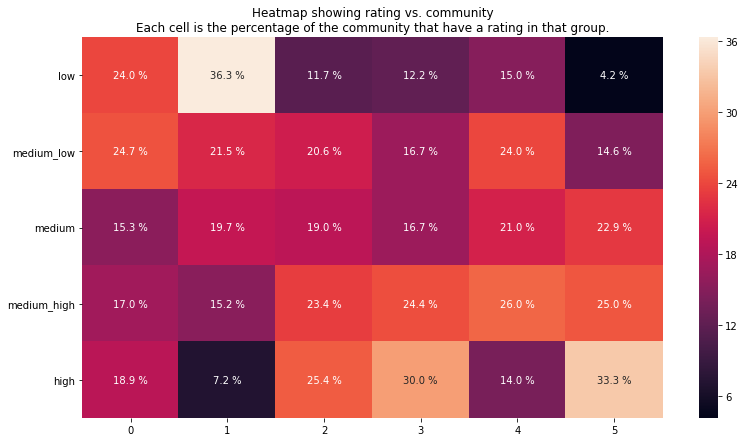

In [563]:
plt.figure(figsize = (13,7))
yticklabels = [l for l in ratings_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt=".1f")
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing rating vs. community\nEach cell is the percentage of the community that have a rating in that group.')
for t in chart.texts: t.set_text(t.get_text() + " %")
plt.show()

There does not seem to be a high correlation between rating and communities. Community 0 and 1 have a larger part of low rating directors while community 2, 3 and 5 have a larger part of high rating directors. Community 4 has the largest part around the medium rating. However there is not a huge difference in the numbers.

### Conclusion about communities
So what can we say about the communities? First of all, the modularity is not significantly high, so the communities are not that solid. We examined different groupings of the directors to see if there is a correlation with the found communities. We tried grouping the directors by language, by genre, by active period and by rating. We discovered the following about the communities:
- Community 0 consists almost solely of directors of english movies. Regarding active period it consists mostly of directors active in the recent decades.
- Community 1 also consist mainly of directors of english movies. It has a high percentage of directors working in drama, thrillers and action. Over half of the community has been rated below medium and most directors were active in the years 1980-2010.
- Community 2 has a higher number of percentage of directors working in many of the smaller languages than the other communities. It consists mainly of directors active after 1990. Almost haf of the community has been rated above average. 
- Community 3 consists mainly of directors of french and italian movies. Most of the directors in that community are working with commedy and drama. The directors have been active in the last 50 or so years. Over half of the community has been rated above average.
- Community 4 is characteries as being the community of directors of older movies. Most directors were active in the years 1940-1990. The genres are also a bit different than of the other communities. These directors were working more in the genres music, history, mystery, western and war which are genres that were more popular a few decades ago than they are today.
- Community 5 consists mainly of directors of japanese and cantonese movies. These directors are directing foreign, fantasy and science fiction movies and a more than a third of the community has received a high rating. 

The analysis showed that some of the communities seem to be defined by attributes such as language (3 and 5) and active period (4) while the others are more mixed and it's harder to distinguish what makes the community. 


So in what communities are our most central directors regarding eigenvector centrality? Our guess would be in the mixed communities 0, 1 or 2. These are afterall also the largest communities and they seem to hold the more mainstreem directors.

In [565]:
for name,d in (list_eigenvector_centrality)[0:5]:
    print(name +': ' + str(partition[name]))

Steven Spielberg: 2
Woody Allen: 1
Ridley Scott: 2
Martin Scorsese: 1
Oliver Stone: 1


The most central nodes are indeed in communies 1 and 2. 

## Network analysis conclusion
We will analyse the structure of the network and the centrality of nodes. Then we will analyse the communities of the network.

The network we created consisted of movie directors which are connected if they have hired the same actors. The structure of the network resembles that of a social network and the small world property holds. The top three directors regarding centrality are all famous directors which have directed a lot of movies and mostly work in the more popular genres. 

We found 6 communities within the network and analysed these to find out what made these communities. We found out that some of the communities seemed to be based on language and the active periods of the directors while some were more a general mix.